In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import pandas as pd

import hdbscan
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

In [2]:
# Load embeddings and correspondance
embeddings = np.load("embeddings/embeddings.npy", allow_pickle=True)
correspondance = np.load("embeddings/correspondance.npy", allow_pickle=True).item()

In [3]:
#Check dimension of the embeddings
print(embeddings.shape)

(49125, 2, 1, 128)


In [4]:
#We select the mean embeddings
mu_embeddings = embeddings[:, 0, 0, :]  # dim explected (49125, 128)

In [5]:
#Before doing anything, as we are going to use KMeans or UMAP, we need to scale the data

#We normalize the data
scaler = StandardScaler()
mu_embeddings_normalized = scaler.fit_transform(mu_embeddings)

# 1.Presentation of the approach

We are going to use two approaches and two different algorithms : first doing clustering an then dimension reduction or the opposite

# 2.First approach: cultering after dim reduction

As we have 128 dimensions, to avoid curse of dimensionality, we decide first to the number of dimensions and then to apply the culstering algorithm. We choose to keep 3 dimensions to be able to watch the data and to keep more information than in 2 dimensions

## 2.1 Dim reduction: UMAP

We start to reduce dimension with UMAP

UMAP(n_components=3, n_jobs=1, random_state=42, verbose=True)
Sun Nov 17 02:20:42 2024 Construct fuzzy simplicial set


c:\Users\antoi\anaconda3\envs\GDA\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Sun Nov 17 02:20:42 2024 Finding Nearest Neighbors
Sun Nov 17 02:20:42 2024 Building RP forest with 16 trees
Sun Nov 17 02:20:47 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Sun Nov 17 02:21:05 2024 Finished Nearest Neighbor Search
Sun Nov 17 02:21:09 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Nov 17 02:22:56 2024 Finished embedding


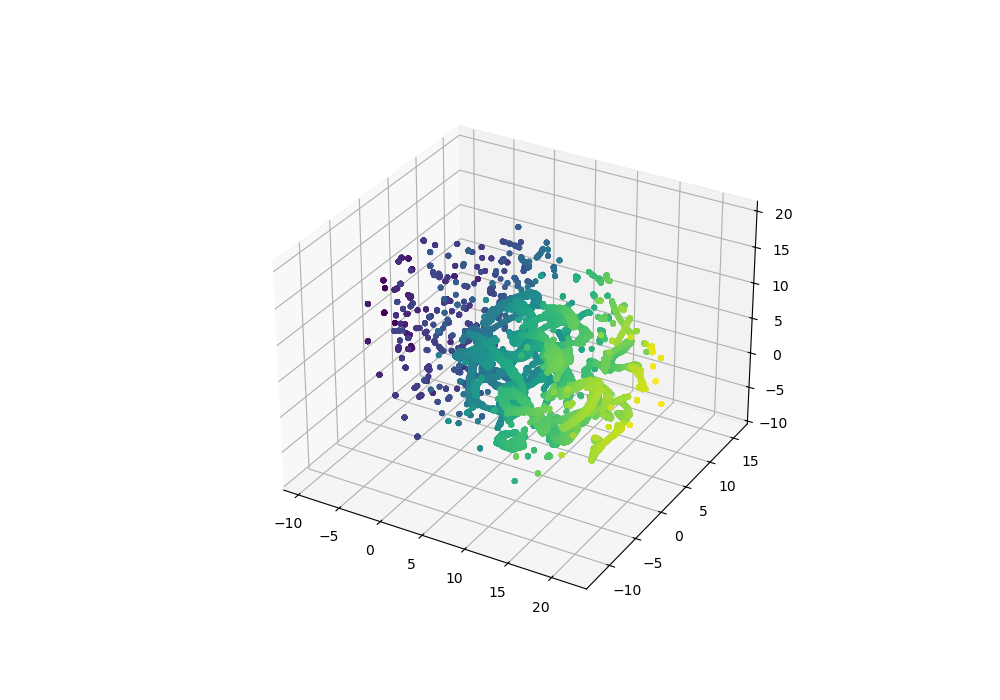

In [6]:
# Reduction of dimension with UMAP
reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42, verbose=True)
projection = reducer.fit_transform(mu_embeddings_normalized)

#Vizualizaition of the UMAP space (3D)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], c=projection[:, 0], cmap='viridis', s=10)

In [7]:
#We appy the Kmeans on the reduced space
n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(projection)
centroids_kmeans = kmeans.cluster_centers_
labels_kmeans = kmeans.labels_

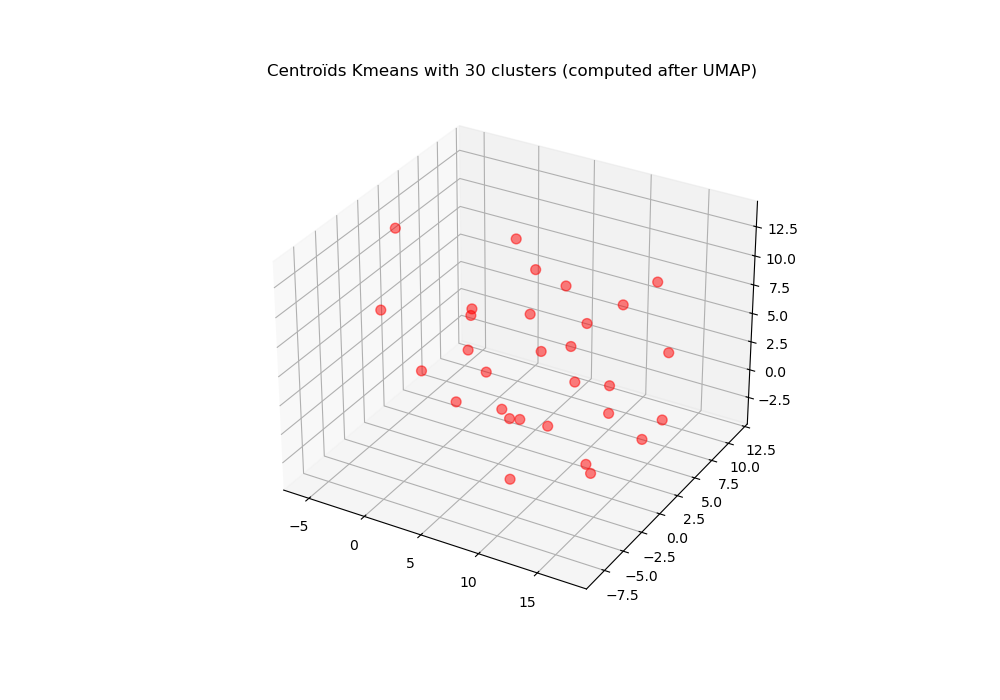

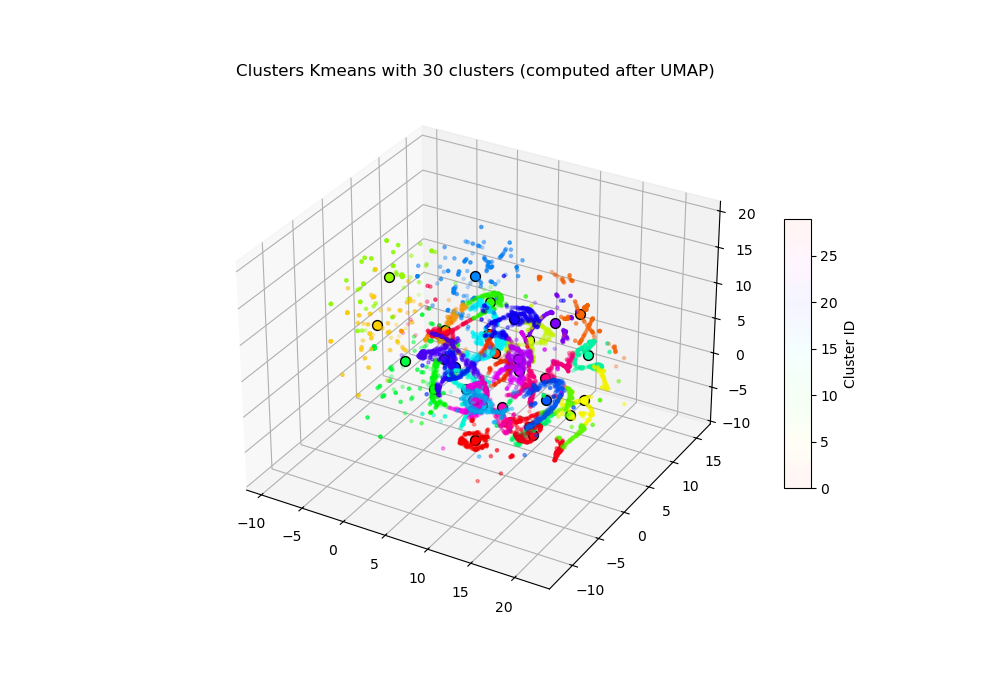

In [8]:
#We plot the results
# Generate a more readable colormap
colors = plt.cm.hsv(np.linspace(0, 1, n_clusters))
custom_cmap = ListedColormap(colors)

# Visualiser les clusters and centroids
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter_clusters  = ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], c=labels_kmeans, s=5, cmap=custom_cmap, alpha = 0.04)
#scatter_clusters  = ax.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], centroids_kmeans[:, 2], c='black', s=50, alpha=1) #If we want centroïds to be black
for i in range(n_clusters):
    ax.scatter(centroids_kmeans[i, 0], centroids_kmeans[i, 1], centroids_kmeans[i, 2], 
               c=colors[i].reshape(1, -1), s=50, edgecolor='black', label=f'Centroid {i}')



cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Clusters Kmeans with {n_clusters} clusters (computed after UMAP)")



fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], centroids_kmeans[:, 2], c='red', s=50, alpha=0.5)
plt.title(f"Centroïds Kmeans with {n_clusters} clusters (computed after UMAP)")
plt.show()


In [9]:
# Silhouette Score
silhouette_avg = silhouette_score(projection, labels_kmeans)
print("Silhouette Score :", silhouette_avg)

Silhouette Score : 0.35865843


In [10]:
#Export centroïds coordinates
centroids_kmeans_csv = pd.DataFrame(centroids_kmeans, columns=["x", "y","z"])
centroids_kmeans_csv["Method"] = "Kmeans_after_UMAP"
centroids_kmeans_csv.to_csv("embeddings/centroids_kmeans_after_dim_reduction.csv")

## 2.2 Dim reduction PCA

We also try to reduce dimension with PCA (linear so maybe the distance in the "PCA" space is more meaninful than in UMAP space?)

In [11]:
#We compute the PCA of the embeddings
pca = PCA(n_components=3)
pca_projection = pca.fit_transform(mu_embeddings_normalized)


In [12]:
#We appy the Kmeans on the reduced space after PCA
n_clusters = 30
kmeans_PCA = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_PCA.fit(pca_projection)

centroids_kmeans_PCA  = kmeans_PCA.cluster_centers_
labels_kmeans_PCA  = kmeans_PCA.labels_

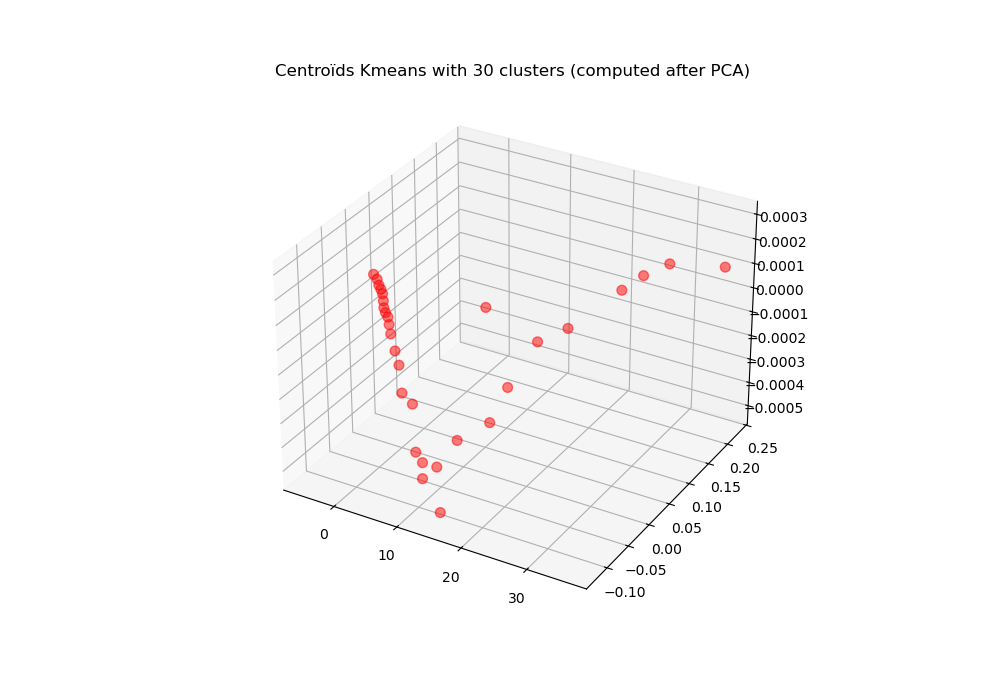

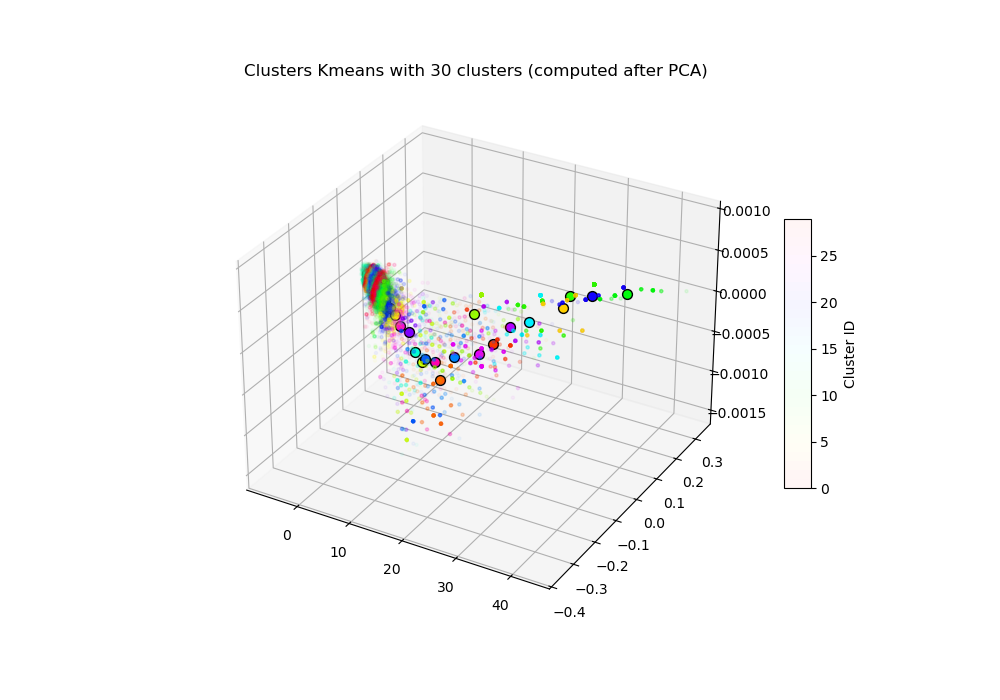

In [13]:
#We plot the results
# Visualiser les clusters and centroids
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter_clusters  = ax.scatter(pca_projection[:, 0], pca_projection[:, 1], pca_projection[:, 2], c=labels_kmeans_PCA, s=5, cmap=custom_cmap, alpha = 0.04)
#scatter_clusters  = ax.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], centroids_kmeans[:, 2], c='black', s=50, alpha=1) #If we want centroïds to be black
for i in range(n_clusters):
    ax.scatter(centroids_kmeans_PCA[i, 0], centroids_kmeans_PCA[i, 1], centroids_kmeans_PCA[i, 2], 
               c=colors[i].reshape(1, -1), s=50, edgecolor='black', label=f'Centroid {i}')



cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Clusters Kmeans with {n_clusters} clusters (computed after PCA)")



fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(centroids_kmeans_PCA[:, 0], centroids_kmeans_PCA[:, 1], centroids_kmeans_PCA[:, 2], c='red', s=50, alpha=0.5)
plt.title(f"Centroïds Kmeans with {n_clusters} clusters (computed after PCA)")
plt.show()


In [14]:
# Silhouette Score
silhouette_avg = silhouette_score(pca_projection, labels_kmeans_PCA)
print("Silhouette Score :", silhouette_avg)

Silhouette Score : 0.5280525


In [15]:
#Export centroïds coordinates
centroids_kmeans_csv = pd.DataFrame(centroids_kmeans_PCA, columns=["x", "y","z"])
centroids_kmeans_csv["Method"] = "Kmeans_after_PCA"
centroids_kmeans_csv.to_csv("embeddings/centroids_kmeans_after_dim_reduction.csv", mode='a', index=False, header=False)

# 2 Second approach: clustering before reduction of dimension

## 2.1 We apply K_means on the whole dataset

In [16]:
#We appy the Kmeans on the whole dataset
kmeans_before = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_before.fit(mu_embeddings_normalized)
centroids_kmeans_before = kmeans_before.cluster_centers_
labels_kmeans_before = kmeans_before.labels_

In [17]:
# Silhouette Score
silhouette_avg = silhouette_score(mu_embeddings_normalized, labels_kmeans_before)
print("Silhouette Score :", silhouette_avg)

Silhouette Score : 0.53050494


## 2.2 Projection in UMAP space to see results

In [18]:
#Project the centroids in the UMAP space
centroids_kmeans_before_projected = reducer.transform(centroids_kmeans_before)

Sun Nov 17 02:25:12 2024 Worst tree score: 0.95928753
Sun Nov 17 02:25:12 2024 Mean tree score: 0.96496183
Sun Nov 17 02:25:12 2024 Best tree score: 0.98585242
Sun Nov 17 02:25:15 2024 Forward diversification reduced edges from 736875 to 321750
Sun Nov 17 02:25:21 2024 Reverse diversification reduced edges from 321750 to 321750
Sun Nov 17 02:25:25 2024 Degree pruning reduced edges from 329712 to 329569
Sun Nov 17 02:25:25 2024 Resorting data and graph based on tree order
Sun Nov 17 02:25:25 2024 Building and compiling search function


Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


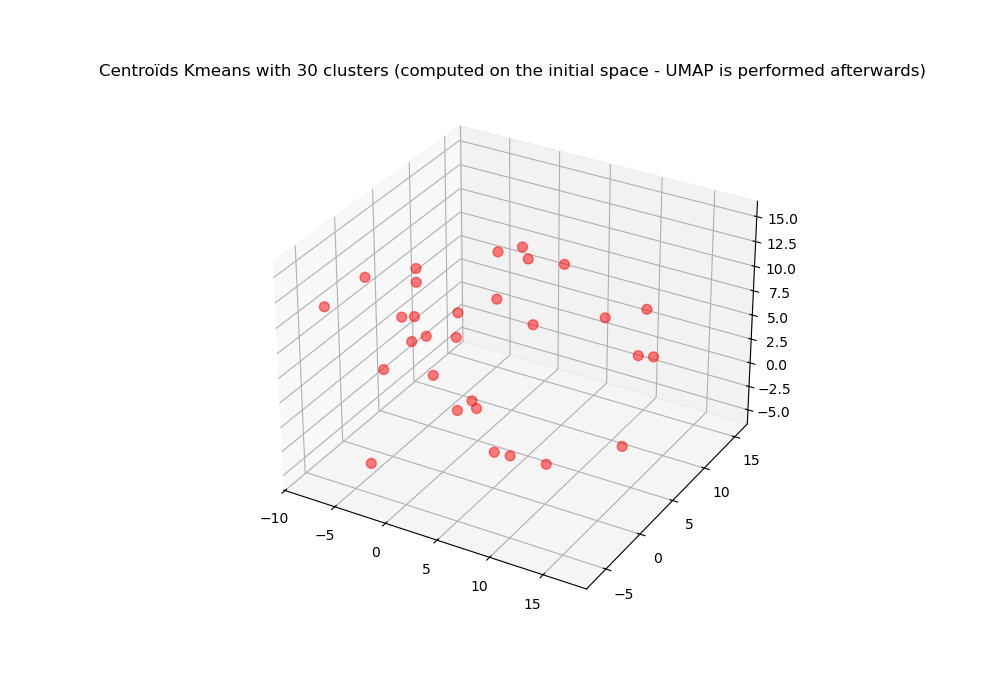

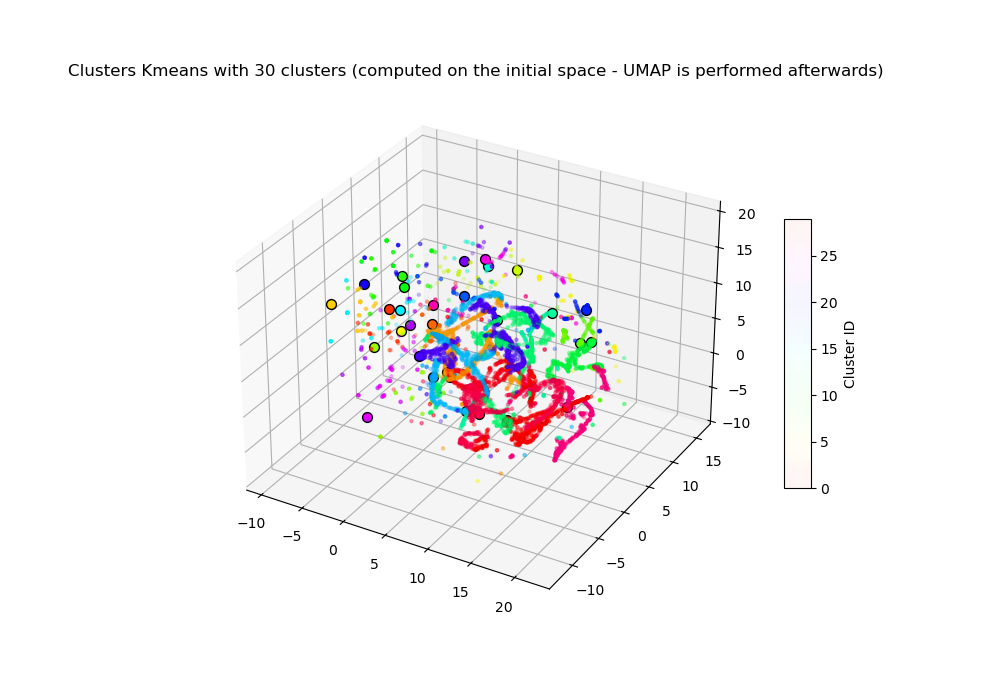

In [19]:
#We plot the results

# Visualiser les clusters and centroids
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter_clusters  = ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], c=labels_kmeans_before, s=5, cmap=custom_cmap, alpha = 0.04)
for i in range(n_clusters):
    ax.scatter(centroids_kmeans_before_projected[i, 0], centroids_kmeans_before_projected[i, 1], centroids_kmeans_before_projected[i, 2], 
               c=colors[i].reshape(1, -1), s=50, edgecolor='black', label=f'Centroid {i}')



cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Clusters Kmeans with {n_clusters} clusters (computed on the initial space - UMAP is performed afterwards)")



fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(centroids_kmeans_before_projected[:, 0], centroids_kmeans_before_projected[:, 1], centroids_kmeans_before_projected[:, 2], c='red', s=50, alpha=0.5)
plt.title(f"Centroïds Kmeans with {n_clusters} clusters (computed on the initial space - UMAP is performed afterwards)")
plt.show()


In [20]:
#Export centroïds coordinates
centroids_kmeans_csv = pd.DataFrame(centroids_kmeans_before)
centroids_kmeans_csv["Method"] = "Kmeans_before"
centroids_kmeans_csv.to_csv("embeddings/centroids_kmeans_before_dim_reduction.csv", index=False, header=False)

## 2.3 Projection with PCA to see results

In [21]:
#Project the centroids in the PCA space
centroids_kmeans_before_projected = pca.transform(centroids_kmeans_before)

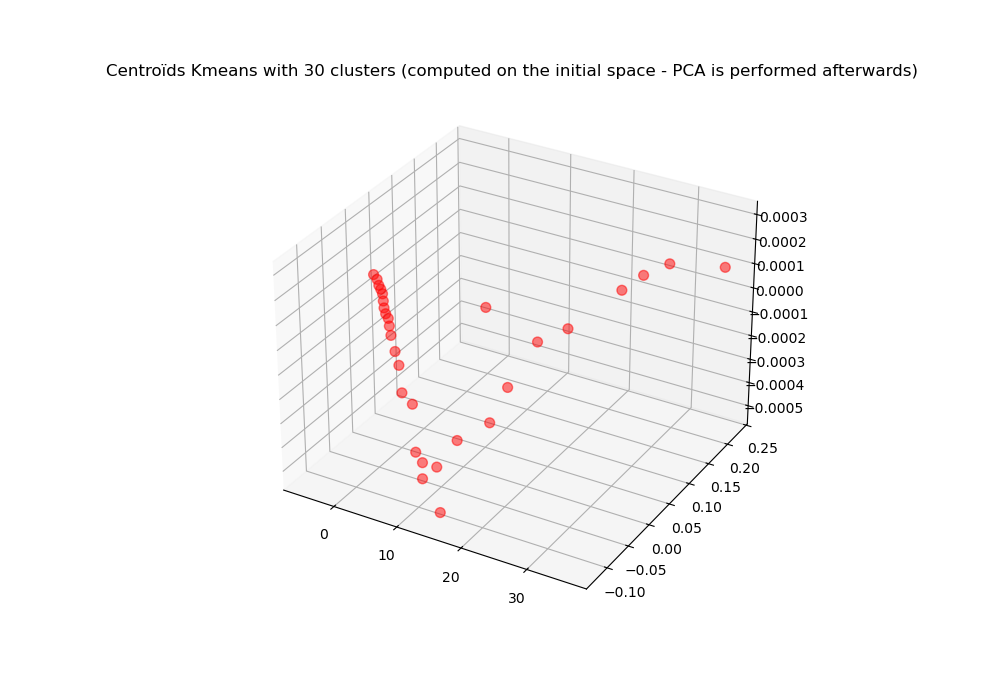

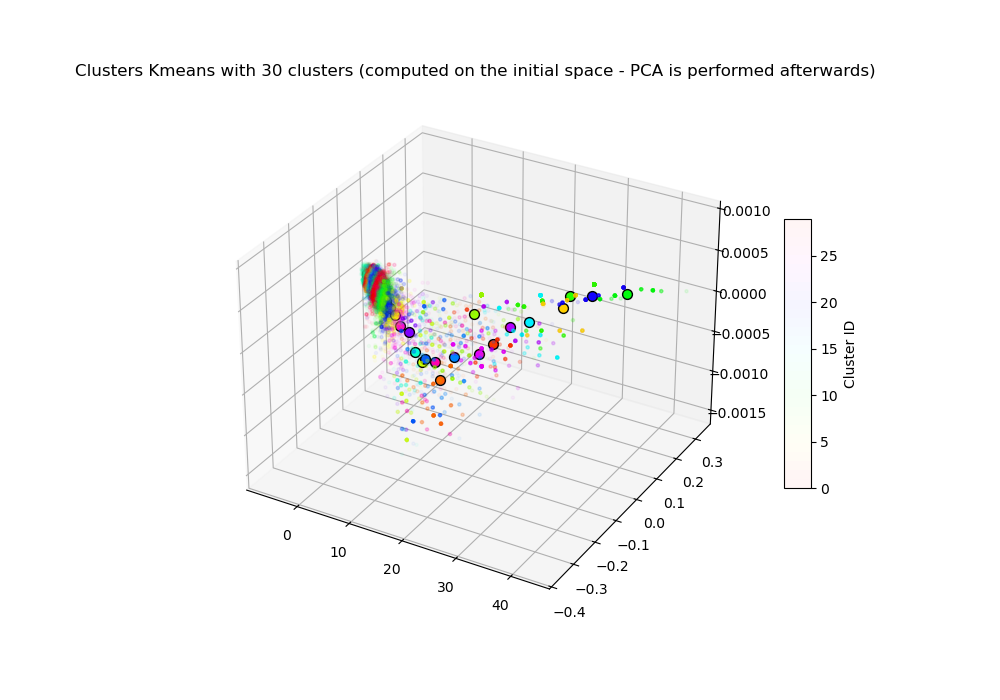

In [22]:
#We plot the results
# Visualiser les clusters and centroids
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter_clusters  = ax.scatter(pca_projection[:, 0], pca_projection[:, 1], pca_projection[:, 2], c=labels_kmeans_before, s=5, cmap=custom_cmap, alpha = 0.04)
for i in range(n_clusters):
    ax.scatter(centroids_kmeans_before_projected[i, 0], centroids_kmeans_before_projected[i, 1], centroids_kmeans_before_projected[i, 2], 
               c=colors[i].reshape(1, -1), s=50, edgecolor='black', label=f'Centroid {i}')



cbar = plt.colorbar(scatter_clusters, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster ID")
plt.title(f"Clusters Kmeans with {n_clusters} clusters (computed on the initial space - PCA is performed afterwards)")



fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(centroids_kmeans_before_projected[:, 0], centroids_kmeans_before_projected[:, 1], centroids_kmeans_before_projected[:, 2], c='red', s=50, alpha=0.5)
plt.title(f"Centroïds Kmeans with {n_clusters} clusters (computed on the initial space - PCA is performed afterwards)")
plt.show()

# We want to look quickly to see whether or not we have curse of dimensionality

## We check the histogram of euclidian distances in the original latent space

Shape des données : (49125, 128)


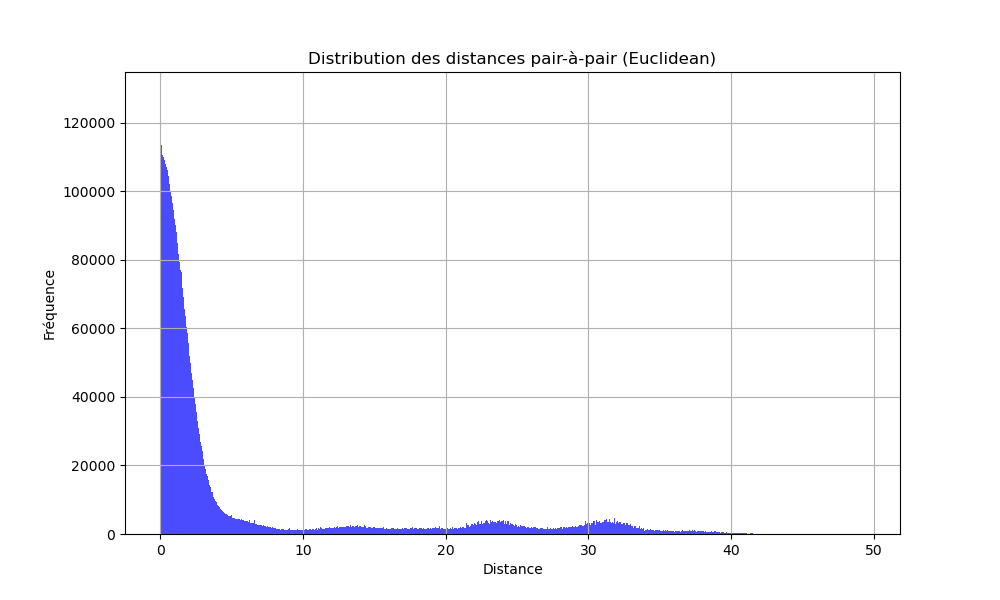

Moyenne des distances : 6.0415
Écart type des distances : 9.6864


In [ ]:
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt

# Étape 1 : Charger les données (128 dimensions)
# Supposons que `mu_embeddings` est ton tableau de données (N, 128)
print(f"Shape des données : {mu_embeddings_normalized.shape}")

# Étape 2 : Prendre un échantillon si les données sont trop grandes
sample_size = 10000  # Limiter à 1000 points pour le calcul des distances
if mu_embeddings_normalized.shape[0] > sample_size:
    indices = np.random.choice(mu_embeddings_normalized.shape[0], size=sample_size, replace=False)
    sampled_data = mu_embeddings_normalized[indices]
else:
    sampled_data = mu_embeddings_normalized

# Étape 3 : Calculer toutes les paires de distances (euclidiennes)
distances = pdist(sampled_data, metric='euclidean')

# Étape 4 : Visualiser la distribution des distances
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=8000, color='blue', alpha=0.7)
plt.title("Distribution des distances pair-à-pair (Euclidean)")
plt.xlabel("Distance")
plt.ylabel("Fréquence")
plt.grid()
plt.show()

# Étape 5 : Vérifier l'écart type et la moyenne
mean_distance = np.mean(distances)
std_distance = np.std(distances)
print(f"Moyenne des distances : {mean_distance:.4f}")
print(f"Écart type des distances : {std_distance:.4f}")


In [33]:
# Moyenne et écart-type
mean_distance = np.mean(distances)
std_distance = np.std(distances)

# Coefficient de variation (CV)
cv = (std_distance / mean_distance) * 100

# Pourcentage dans ±1σ
lower_bound = mean_distance - std_distance
upper_bound = mean_distance + std_distance
percent_within_1std = np.sum((distances >= lower_bound) & (distances <= upper_bound)) / len(distances) * 100

# Résultats
print(f"Moyenne des distances : {mean_distance:.4f}")
print(f"Écart type des distances : {std_distance:.4f}")
print(f"Coefficient de variation : {cv:.2f}%")
print(f"Pourcentage de distances dans ±1σ : {percent_within_1std:.2f}%")

Moyenne des distances : 6.0415
Écart type des distances : 9.6864
Coefficient de variation : 160.33%
Pourcentage de distances dans ±1σ : 84.17%


## We check the histogram of euclidian distances after PCA (and the importance of each PCA component)

Shape des données : (49125, 3)


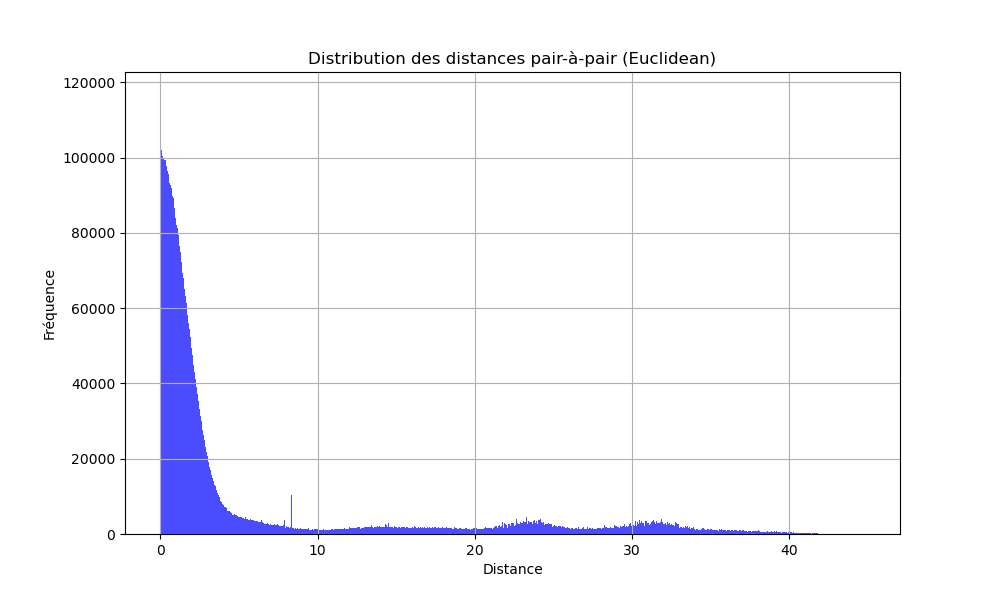

Moyenne des distances : 5.9978
Écart type des distances : 9.6728
Valeurs propres : [ 6.49987640e+01  2.55206460e-03  4.14398201e-05  3.54599906e-05
  3.15145371e-05  1.59541523e-05  1.25871320e-05  1.07594842e-05
  1.07238911e-05  4.68368125e-06  3.85604699e-06  3.27411999e-06
  3.07057576e-06  2.70161286e-06  2.50638982e-06  2.35134439e-06
  2.34735057e-06  2.02013803e-06  1.88288993e-06  1.74941329e-06
  1.67738108e-06  1.50757660e-06  1.43817840e-06  1.32474906e-06
  1.01709918e-06  9.43714269e-07  8.56575809e-07  7.49521973e-07
  6.47119748e-07  4.34625036e-07  3.74571869e-07  2.82227575e-07
  1.68391068e-07  1.11149143e-08  3.97348243e-21  1.25071254e-21
  5.77998057e-22  3.33852170e-22  3.07450069e-22  2.48040613e-22
  1.91464796e-22  1.68555039e-22  1.19509196e-22  5.82491737e-23
  2.99029622e-23  1.88332731e-23  1.10695045e-23  8.23721507e-25
  1.07256001e-37  7.52997707e-38  3.26715259e-38  2.34333383e-38
  1.58682351e-38  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.000

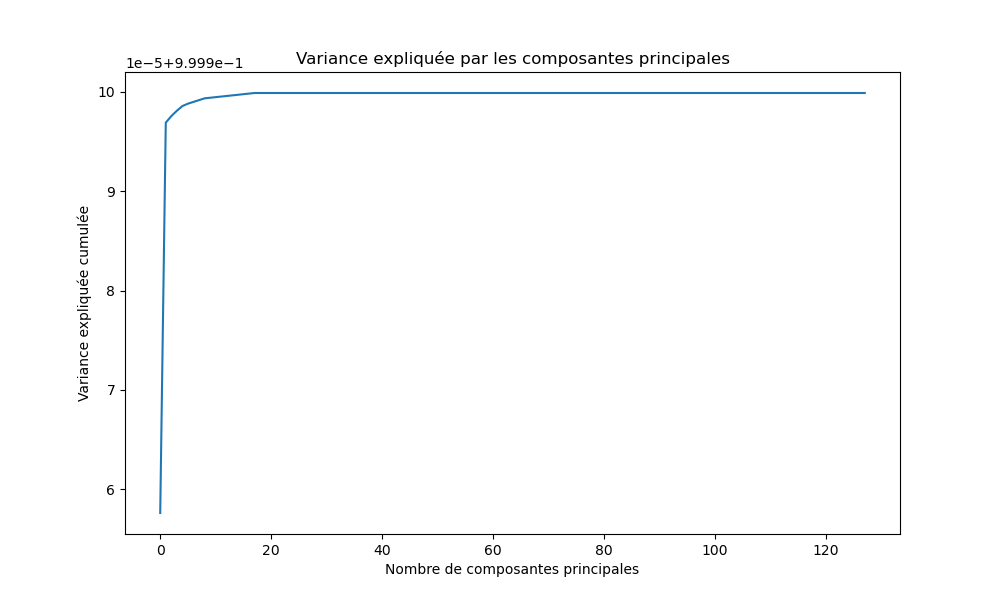

In [40]:
# Étape 1 : Charger les données (128 dimensions)
# Supposons que `mu_embeddings` est ton tableau de données (N, 128)
print(f"Shape des données : {pca_projection.shape}")

# Étape 2 : Prendre un échantillon si les données sont trop grandes
sample_size = 10000  # Limiter à 1000 points pour le calcul des distances
if pca_projection.shape[0] > sample_size:
    indices = np.random.choice(pca_projection.shape[0], size=sample_size, replace=False)
    sampled_data = pca_projection[indices]
else:
    sampled_data = pca_projection

# Étape 3 : Calculer toutes les paires de distances (euclidiennes)
distances = pdist(sampled_data, metric='euclidean')

# Étape 4 : Visualiser la distribution des distances
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=8000, color='blue', alpha=0.7)
plt.title("Distribution des distances pair-à-pair (Euclidean)")
plt.xlabel("Distance")
plt.ylabel("Fréquence")
plt.grid()
plt.show()

# Étape 5 : Vérifier l'écart type et la moyenne
mean_distance = np.mean(distances)
std_distance = np.std(distances)
print(f"Moyenne des distances : {mean_distance:.4f}")
print(f"Écart type des distances : {std_distance:.4f}")



# Variance expliquée cumulative
all_pca = PCA()
all_pca.fit(mu_embeddings_normalized)
print("Valeurs propres :", all_pca.explained_variance_)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(all_pca.explained_variance_ratio_))
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée par les composantes principales")
plt.show()

## We check the histogram of euclidian distances after UMAP

Shape des données : (49125, 3)


C:\Users\antoi\AppData\Local\Temp\ipykernel_45432\3809568531.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


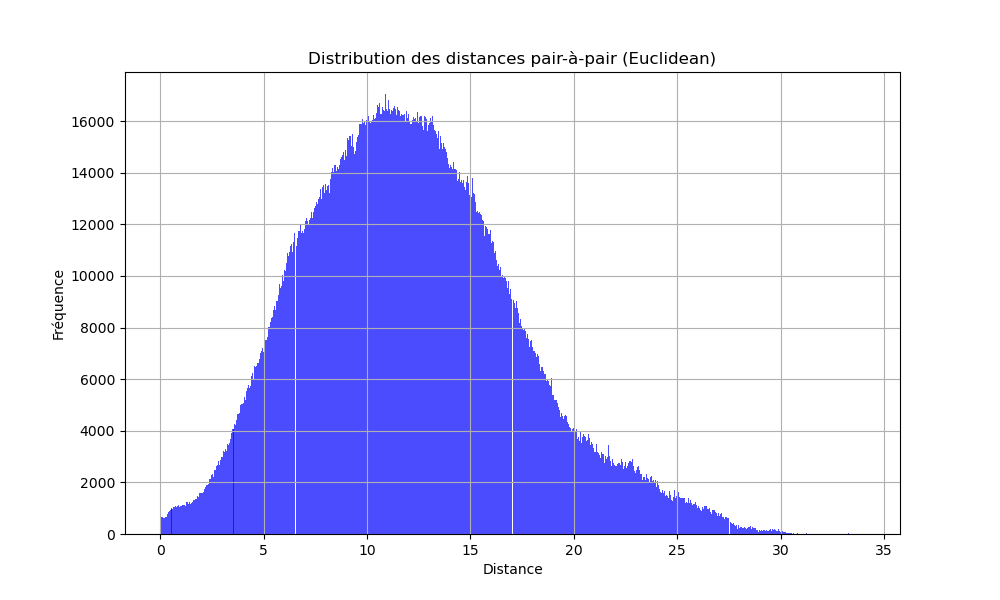

Moyenne des distances : 12.1679
Écart type des distances : 5.1632


In [37]:

# Étape 1 : Charger les données (128 dimensions)
# Supposons que `mu_embeddings` est ton tableau de données (N, 128)
print(f"Shape des données : {projection.shape}")

# Étape 2 : Prendre un échantillon si les données sont trop grandes
sample_size = 10000  # Limiter à 1000 points pour le calcul des distances
if projection.shape[0] > sample_size:
    indices = np.random.choice(projection.shape[0], size=sample_size, replace=False)
    sampled_data = projection[indices]
else:
    sampled_data = projection

# Étape 3 : Calculer toutes les paires de distances (euclidiennes)
distances = pdist(sampled_data, metric='euclidean')

# Étape 4 : Visualiser la distribution des distances
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=8000, color='blue', alpha=0.7)
plt.title("Distribution des distances pair-à-pair (Euclidean)")
plt.xlabel("Distance")
plt.ylabel("Fréquence")
plt.grid()
plt.show()

# Étape 5 : Vérifier l'écart type et la moyenne
mean_distance = np.mean(distances)
std_distance = np.std(distances)
print(f"Moyenne des distances : {mean_distance:.4f}")
print(f"Écart type des distances : {std_distance:.4f}")